# RBMs and DBNs

### Load mnist datasets

In [1]:
import pandas as pd
from torchvision.datasets import FashionMNIST, KMNIST, MNIST

mnist = MNIST(
    root="data/mnist",
    download=True,
)

mnist_test = MNIST(root="data/mnist", download=True, train=False)

fashion = FashionMNIST(
    root="data/fmnist",
    download=True,
)
fashion_test = FashionMNIST(root="data/fmnist", download=True, train=False)

kuzushiji = KMNIST(
    root="data/kmnist",
    download=True,
)
kuzushiji_test = KMNIST(root="data/kmnist", download=True, train=False)

In [2]:
mnist_train_data = mnist.data
mnist_train_labels = mnist.train_labels.numpy()
mnist_test_data = mnist_test.data
mnist_test_labels = mnist_test.targets.numpy()

fashion_train_data = fashion.train_data
fashion_train_labels = fashion.train_labels.numpy()
fashion_test_data = fashion_test.data
fashion_test_labels = fashion_test.targets.numpy()

kuzushiji_train_data = kuzushiji.train_data
kuzushiji_train_labels = kuzushiji.train_labels.numpy()
kuzushiji_test_data = kuzushiji_test.data
kuzushiji_test_labels = kuzushiji_test.targets.numpy()

C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


### Preprocess datasets

In [3]:
import numpy as np

Histogram normalization

In [4]:
def normalize(images):

    histograms = np.apply_along_axis(
        np.bincount, 1, images.reshape(images.shape[0], -1), minlength=256
    )

    cdf = histograms.cumsum(axis=1)
    cdf_min = cdf[:, 0][
        :, None
    ]  # Minimum of the CDF (first non-zero element in each row)

    # Normalize the CDF for each image
    cdf_m = ((cdf - cdf_min) * 255) / (cdf.max(axis=1)[:, None] - cdf_min)

    cdf_m = cdf_m.astype(np.uint8)

    # Apply normalized CDF to each image
    normalized_images = cdf_m[
        np.arange(images.shape[0])[:, None, None], images
    ]  #  Broadcasting across images and index

    return normalized_images

In [5]:
mnist_train_data = normalize(mnist_train_data) > 63
mnist_test_data = normalize(mnist_test_data) > 63

fashion_train_data = normalize(fashion_train_data) > 63
fashion_test_data = normalize(fashion_test_data) > 63

kuzushiji_train_data = normalize(kuzushiji_train_data) > 99
kuzushiji_test_data = normalize(kuzushiji_test_data) > 99

### Display images

In [65]:
import matplotlib.pyplot as plt
from pathlib import Path


def display_images(images, title="", cols=5, save=None, display=True):
    # Ensure we only display up to the number of images available
    num_images = images.shape[0]

    # Set up a grid for the images

    rows = (
        num_images + cols - 1
    ) // cols  # Calculate rows needed for the number of images

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10 / cols * rows))
    fig.suptitle(title)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i], cmap="gray")
        ax.axis("off")

    if display:
        plt.plot()

    if save:
        save_path = Path(save)
        save_path.parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(save_path, format="png")

    plt.close()

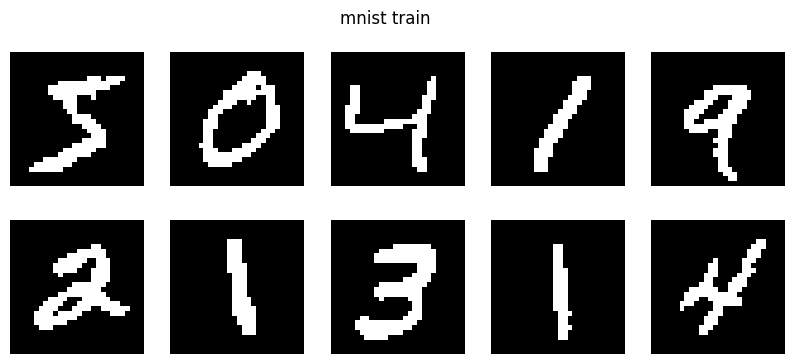

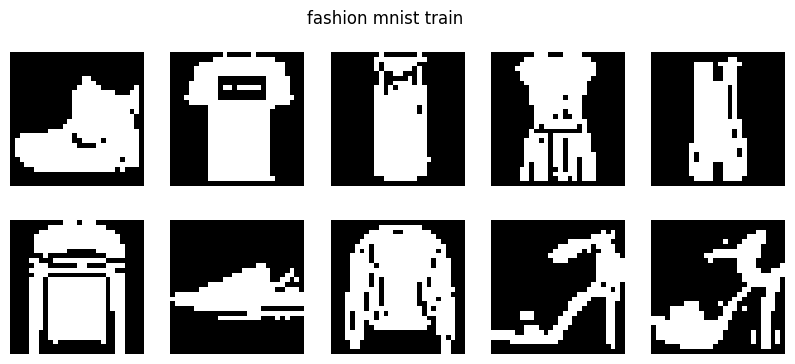

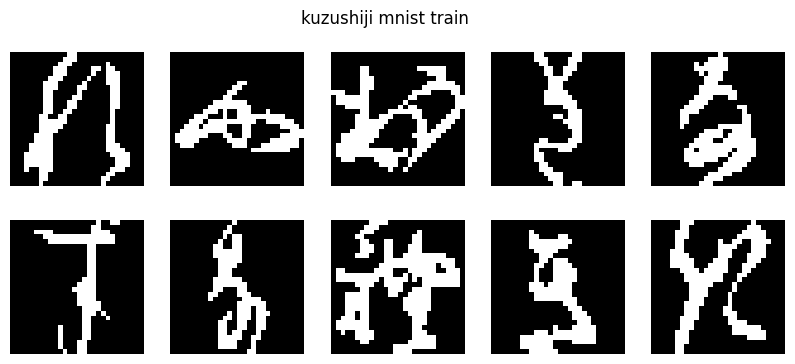

In [35]:
display_images(mnist_train_data[:10], "mnist train")
display_images(fashion_train_data[:10], "fashion mnist train")
display_images(kuzushiji_train_data[:10], "kuzushiji mnist train")

In [37]:
mnist = [mnist_train_data, mnist_train_labels, mnist_test_data, mnist_test_labels]
fashion = [
    fashion_train_data,
    fashion_train_labels,
    fashion_test_data,
    fashion_test_labels,
]
kuzushiji = [
    kuzushiji_train_data,
    kuzushiji_train_labels,
    kuzushiji_test_data,
    kuzushiji_test_labels,
]

datasets = [mnist, fashion, kuzushiji]
names = ("mnist", "fashion_mnist", "kuzushiji_mnist")

# Task 1 - RBM feature extraction

### Baseline

In [9]:
import pandas as pd


# retunrs a dataframe with socres for each class and scores combined
def get_score_df(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)

    result_df = pd.DataFrame(columns=["label", "auroc", "f1", "prec", "rec"])
    classes = np.unique(y_test)  # Assuming y_train contains all classes
    for cls in classes:
        binary_y_test = (y_test == cls).astype(int)
        binary_y_pred = (y_pred == cls).astype(int)

        auroc = roc_auc_score(binary_y_test, y_prob[:, cls])
        f1 = f1_score(binary_y_test, binary_y_pred)
        precision = precision_score(binary_y_test, binary_y_pred)
        recall = recall_score(binary_y_test, binary_y_pred)

        result_df.loc[result_df.shape[0]] = [cls, auroc, f1, precision, recall]

    auroc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    result_df.loc[result_df.shape[0]] = ["all", auroc, f1, precision, recall]

    return result_df

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

baseline_dataframes = []
for data, name in zip(datasets, names):
    print(f"Training for {name}")
    X_train, y_train, X_test, y_test = data
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    clf = LogisticRegression(n_jobs=-1, random_state=42)

    clf.fit(X_train, y_train)

    result_df = get_score_df(clf, X_test, y_test)

    baseline_dataframes.append(result_df)

    print(result_df)
    print()

Training for mnist
   label     auroc        f1      prec       rec
0    0.0  0.998814  0.959235  0.946375  0.972449
1    1.0  0.998860  0.978929  0.975503  0.982379
2    2.0  0.989151  0.910440  0.930233  0.891473
3    3.0  0.992957  0.894325  0.883946  0.904950
4    4.0  0.995786  0.919028  0.913481  0.924644
5    5.0  0.988035  0.876147  0.896714  0.856502
6    6.0  0.997391  0.940691  0.929664  0.951983
7    7.0  0.993401  0.928188  0.932287  0.924125
8    8.0  0.990451  0.881183  0.875380  0.887064
9    9.0  0.992254  0.899651  0.906439  0.892963
10   all  0.993802  0.919936  0.920056  0.920100

Training for fashion mnist
   label     auroc        f1      prec     rec
0    0.0  0.979829  0.802165  0.789729  0.8150
1    1.0  0.997567  0.963489  0.977366  0.9500
2    2.0  0.965686  0.711067  0.712136  0.7100
3    3.0  0.986849  0.841231  0.822350  0.8610
4    4.0  0.968594  0.720773  0.697196  0.7460
5    5.0  0.997695  0.933197  0.952133  0.9150
6    6.0  0.921319  0.550725  0.5944

### Tune and train a pipeline

In [11]:
# the tuning takes a lot of time. Grids computed once are reused when we run the notebook

perform_tuning = False

best_param_grids = [
    {
        "logreg__C": 0.5,
        "rbm__batch_size": 5,
        "rbm__learning_rate": 0.01,
        "rbm__n_components": 128,
    },
    {
        "logreg__C": 1.0,
        "rbm__batch_size": 10,
        "rbm__learning_rate": 0.01,
        "rbm__n_components": 128,
    },
    {
        "logreg__C": 1.0,
        "rbm__batch_size": 10,
        "rbm__learning_rate": 0.1,
        "rbm__n_components": 128,
    },
]

In [12]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

scoring_func = lambda true, pred: roc_auc_score(
    true, pred, multi_class="ovr", average="weighted"
)

multiclass_auroc_scorer = make_scorer(
    scoring_func, needs_proba=True, greater_is_better=True
)

rbm_dataframes = []
estims = []
for data, name, best_params in zip(datasets, names, best_param_grids):
    print(f"Training for {name}")
    X_train, y_train, X_test, y_test = data
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    clf = Pipeline(
        [
            ("rbm", BernoulliRBM(random_state=42)),
            ("logreg", LogisticRegression(random_state=42)),
        ]
    )

    if perform_tuning:

        param_grid = {
            "rbm__n_components": [64, 96, 128],  # Number of hidden units
            "rbm__learning_rate": [0.01, 0.1],  # Learning rate
            "rbm__batch_size": [5, 10, 15],  # Batch size
            "logreg__C": [0.5, 1.0],  # Regularization strength
        }

        clf = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=5,
            scoring=multiclass_auroc_scorer,
            n_jobs=-1,
            verbose=2,
        )
    else:
        clf.set_params(**best_params)

    clf.fit(X_train, y_train)
    result_df = get_score_df(clf, X_test, y_test)
    rbm_dataframes.append(result_df)

    if perform_tuning:
        print(clf.best_params_)
        estims.append(clf.best_estimator_)
    else:
        estims.append(clf)

    print(result_df)
    print()

Training for mnist


C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   label     auroc        f1      prec       rec
0    0.0  0.999438  0.967677  0.958000  0.977551
1    1.0  0.999527  0.987654  0.988526  0.986784
2    2.0  0.996007  0.943066  0.947214  0.938953
3    3.0  0.996799  0.936445  0.939243  0.933663
4    4.0  0.997042  0.939068  0.944387  0.933809
5    5.0  0.997017  0.934463  0.941913  0.927130
6    6.0  0.998670  0.952874  0.945529  0.960334
7    7.0  0.997034  0.945098  0.952569  0.937743
8    8.0  0.995977  0.923941  0.918782  0.929158
9    9.0  0.994860  0.921182  0.915769  0.926660
10   all  0.997257  0.945788  0.945851  0.945800

Training for fashion mnist


C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   label     auroc        f1      prec     rec
0    0.0  0.980692  0.778550  0.773176  0.7840
1    1.0  0.997951  0.966429  0.983437  0.9500
2    2.0  0.965642  0.693556  0.682478  0.7050
3    3.0  0.989003  0.839980  0.827352  0.8530
4    4.0  0.967846  0.689142  0.683382  0.6950
5    5.0  0.996762  0.928793  0.959488  0.9000
6    6.0  0.918536  0.512500  0.534783  0.4920
7    7.0  0.995951  0.902778  0.895669  0.9100
8    8.0  0.995470  0.946640  0.935547  0.9580
9    9.0  0.996535  0.909358  0.891451  0.9280
10   all  0.980439  0.816773  0.816676  0.8175

Training for kuzushiji mnist
   label     auroc        f1      prec     rec
0    0.0  0.985457  0.832139  0.852201  0.8130
1    1.0  0.951712  0.716157  0.695570  0.7380
2    2.0  0.917610  0.632554  0.616920  0.6490
3    3.0  0.986182  0.838996  0.826382  0.8520
4    4.0  0.957735  0.704958  0.692382  0.7180
5    5.0  0.968595  0.811828  0.877907  0.7550
6    6.0  0.971158  0.741531  0.691775  0.7990
7    7.0  0.974384  0.788747  

We managed to improve the results for mnist and kuzushiji mnist datasets.

The results after tuning for fashion mnist are a little worse than for the baseline.

### Plot weights

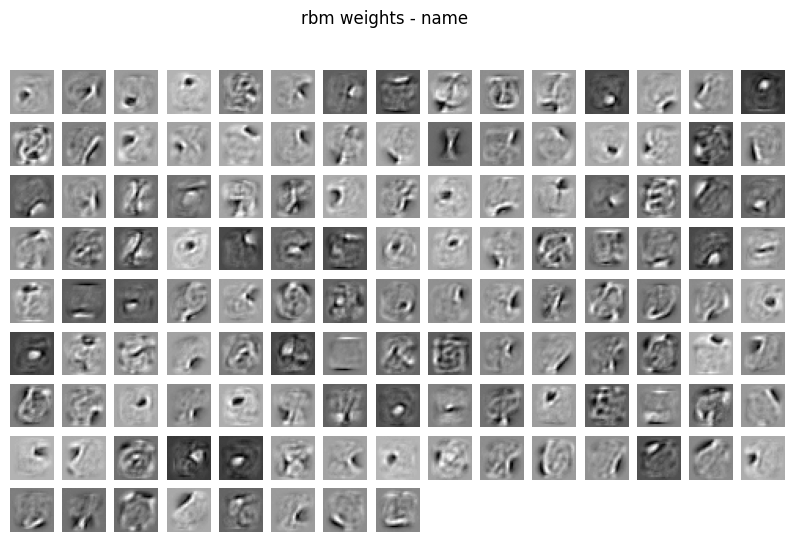

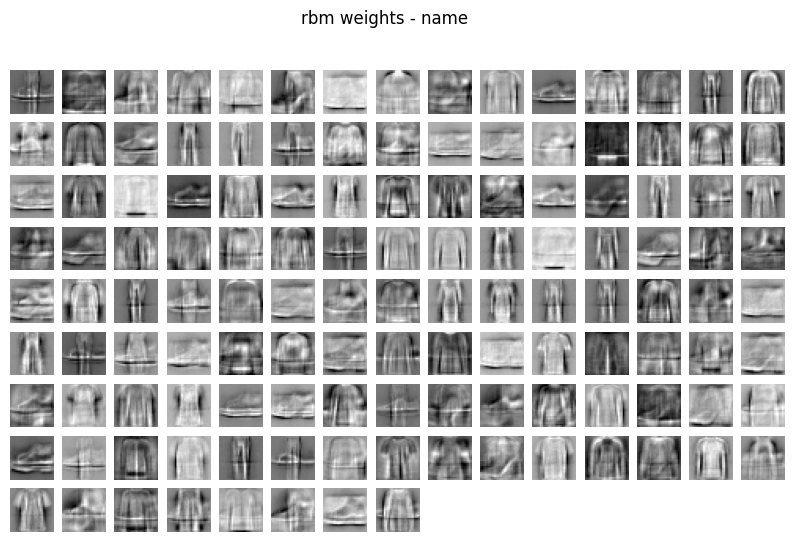

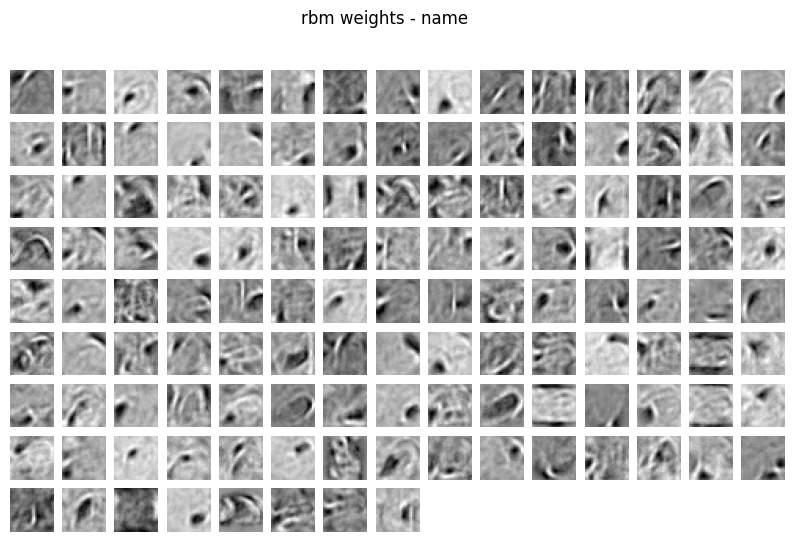

In [13]:
for clf, name in zip(estims, names):
    weights_plotted = clf.named_steps["rbm"].components_.reshape(-1, 28, 28)
    display_images(weights_plotted, cols=15, title=f"rbm weights - name")

It looks like the features of different classes are mixed on different images. It's especially visible for fashion mnist

# Task 2 - DBN

In [14]:
rbm_grids = [
    {
        "batch_size": 5,
        "learning_rate": 0.01,
    },
    {
        "batch_size": 10,
        "learning_rate": 0.01,
    },
    {
        "batch_size": 10,
        "learning_rate": 0.1,
    },
]

components = [(256, 128, 64), (256, 128, 64), (256, 128, 64)]

for data, name, params, n_comps in zip(datasets, names, rbm_grids, components):
    print(f"Training for {name}")
    X_train, y_train, X_test, y_test = data
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    rbm_1 = BernoulliRBM(random_state=42, n_components=n_comps[0], **params)
    rbm_2 = BernoulliRBM(random_state=42, n_components=n_comps[1], **params)
    rbm_3 = BernoulliRBM(random_state=42, n_components=n_comps[2], **params)

    data = [(X_train, X_test)]

    for i, rbm in enumerate([rbm_1, rbm_2, rbm_3]):
        print(f"Training rbm {i+1}")
        train_features = rbm.fit_transform(data[-1][0])
        test_features = rbm.transform(data[-1][1])
        data.append((train_features, test_features))

    for (train_data, test_data), feature_name in zip(
        data, ["raw", "rbm 1", "rbm 2", "rbm 3"]
    ):
        print(f"training regression for {feature_name} features")
        logreg = LogisticRegression(random_state=42, n_jobs=-1)

        logreg.fit(train_data, y_train)
        result_df = get_score_df(logreg, test_data, y_test)

        print(result_df.loc[result_df.shape[0] - 1])
    print()

Training for mnist
Training rbm 1
Training rbm 2
Training rbm 3
training regression for raw features
label         all
auroc    0.993802
f1       0.919936
prec     0.920056
rec        0.9201
Name: 10, dtype: object
training regression for rbm 1 features
label         all
auroc    0.998775
f1       0.961383
prec     0.961416
rec        0.9614
Name: 10, dtype: object
training regression for rbm 2 features
label         all
auroc    0.998367
f1       0.957684
prec     0.957722
rec        0.9577
Name: 10, dtype: object
training regression for rbm 3 features
label         all
auroc    0.997093
f1        0.94867
prec     0.948773
rec        0.9487
Name: 10, dtype: object

Training for fashion mnist
Training rbm 1
Training rbm 2
Training rbm 3
training regression for raw features
label         all
auroc    0.980538
f1       0.829395
prec     0.829049
rec        0.8308
Name: 10, dtype: object
training regression for rbm 1 features
label         all
auroc    0.983483
f1       0.839362
prec     

For the first layer on all datasets we achieved better scores than before! That's likely caused by larger size of hidden state vector that was not included in hyperparameter grid search.

### RBM implementation

In [76]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))


def chunks(seq, size):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def append_ones(matrix):
    return np.concatenate(
        (matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1
    )


class RBM:
    def __init__(self, hidden_size, lr=0.1, verbose=False, mc_steps=5, savedir=None):
        # final column - biases
        self.lr = lr
        self.W = None
        self.hidden_size = hidden_size
        self.verbose = verbose
        self.mc_steps = mc_steps
        self.savedir = savedir

    def fit(self, X, epochs=10, batch_size=50, display=False):
        self.visible_size = X.shape[-1]

        # the last column and last row store bias values
        self.W = np.random.normal(
            scale=0.01, size=(self.visible_size + 1, self.hidden_size + 1)
        ).astype(np.float32)

        self.W[-1] = 0
        self.W[:, -1] = 0

        for epoch in range(epochs):
            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}")
            for batch in chunks(X, batch_size):

                # wake

                v_pos = append_ones(batch)
                h_pos = append_ones(sigmoid(v_pos @ self.W[:, :-1]))
                delta_p = (v_pos.T @ h_pos) / batch.shape[0]

                # dream

                # dummy hidden negative
                h_neg = (h_pos > np.random.rand(*h_pos.shape)).astype(np.float32)

                for _ in range(self.mc_steps - 1):
                    v_neg = sigmoid(h_neg @ self.W[:-1, :].T)
                    v_neg = v_neg > np.random.rand(*v_pos[:, :-1].shape)
                    v_neg = append_ones(v_neg).astype(np.float32)

                    h_neg = sigmoid(v_neg @ self.W[:, :-1])
                    h_neg = h_neg > np.random.rand(*h_pos[:, :-1].shape)
                    h_neg = append_ones(h_neg).astype(np.float32)

                v_neg = sigmoid(h_neg @ self.W[:-1, :].T)
                v_neg = v_neg > np.random.rand(*v_pos[:, :-1].shape)
                v_neg = append_ones(v_neg).astype(np.float32)

                # final negative hidden is computed without probing
                h_neg = sigmoid(v_neg @ self.W[:, :-1])
                h_neg = append_ones(h_neg).astype(np.float32)

                delta_n = (v_neg.T @ h_neg) / batch.shape[0]

                self.W += self.lr * (delta_p - delta_n)

            self.plot_weights(epoch, display=display)

    def reconstruct(self, X):
        if len(X.shape) == 1:
            X = X[None, :]
        hidden = sigmoid(append_ones(X) @ self.W[:, :-1])
        hidden = (hidden > np.random.rand(*hidden.shape)).astype(np.float32)
        hidden = append_ones(hidden)
        reconstructed = sigmoid(hidden @ self.W[:-1, :].T)

        return reconstructed
        #   reconstruct the data from the hidden encoding

    def plot_weights(self, step=0, display=False):
        save_path = None
        if self.savedir:
            save_path = f"{self.savedir}/rbm_state_{step}.png"
        display_images(
            rbm.W.T[:-1, :-1].reshape(-1, 28, 28),
            cols=8,
            title=f"{step}",
            save=save_path,
            display=display,
        )

In [77]:
from PIL import Image

rbms = []
epochs = 50

for data, name in zip(datasets, names):
    print(f"Processing {name}")
    images, _, _, _ = data

    rbm = RBM(hidden_size=32, verbose=True, savedir=f"data/{name}_rbm_weights")

    rbm.fit(images.reshape(images.shape[0], -1), epochs=50, batch_size=128)
    rbms.append(rbm)

    img_path = Path("data", f"{name}_rbm_weights")
    images = [img_path / f"rbm_state_{step}.png" for step in range(epochs)]
    images = [Image.open(img) for img in images]

    # Save as GIF
    images[0].save(
        f"data/{name}_rbm_weights/animated_weights_{name}.gif",
        save_all=True,
        append_images=images[1:],
        format="GIF",
    )

Processing mnist
Epoch 0


C:\Users\piotr\AppData\Local\Temp\ipykernel_23240\911360489.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-matrix))


Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Processing fashion_mnist
Epoch 0
Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45
Processing kuzushiji_mnist
Epoch 0
Epoch 5
Epoch 10
Epoch 15
Epoch 20
Epoch 25
Epoch 30
Epoch 35
Epoch 40
Epoch 45


C:\Users\piotr\AppData\Local\Temp\ipykernel_23240\911360489.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-matrix))


ssim score: 0.6901257680059097


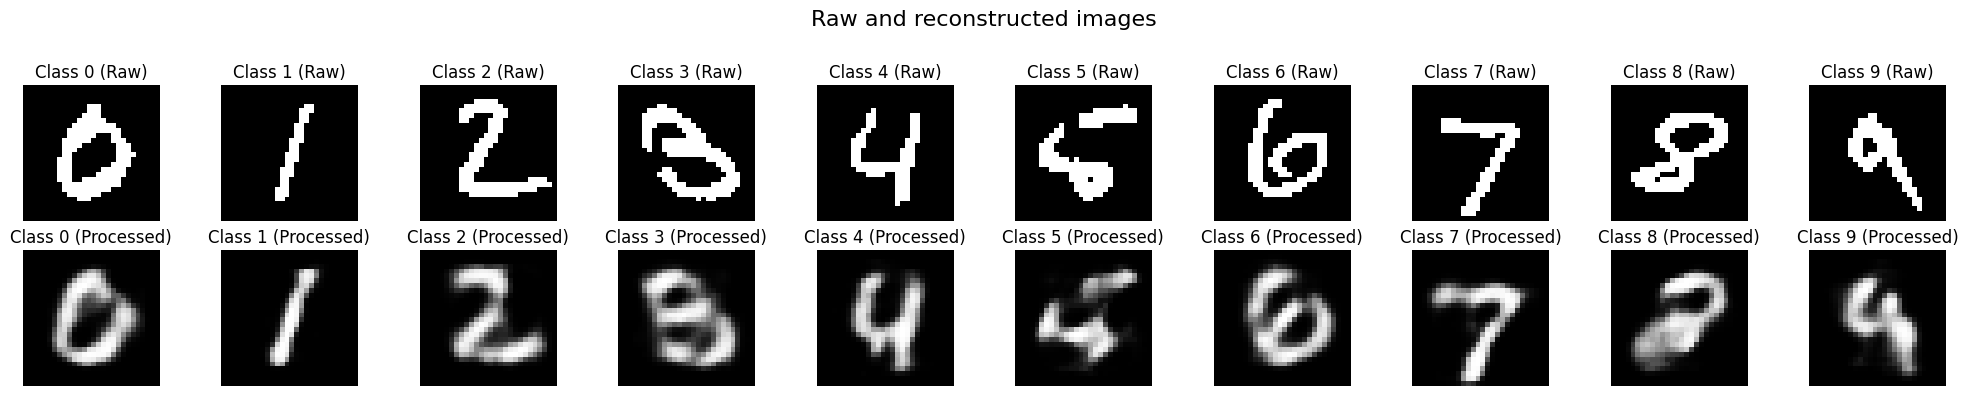

ssim score: 0.7287443817819048


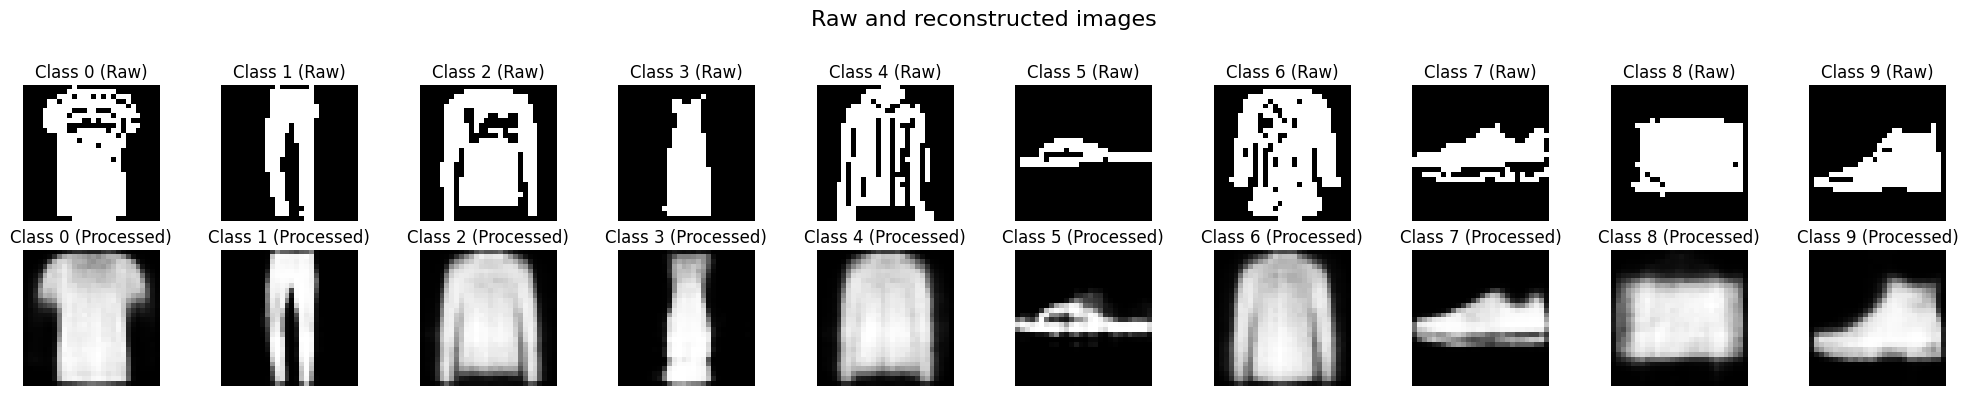

ssim score: 0.4845642611902885


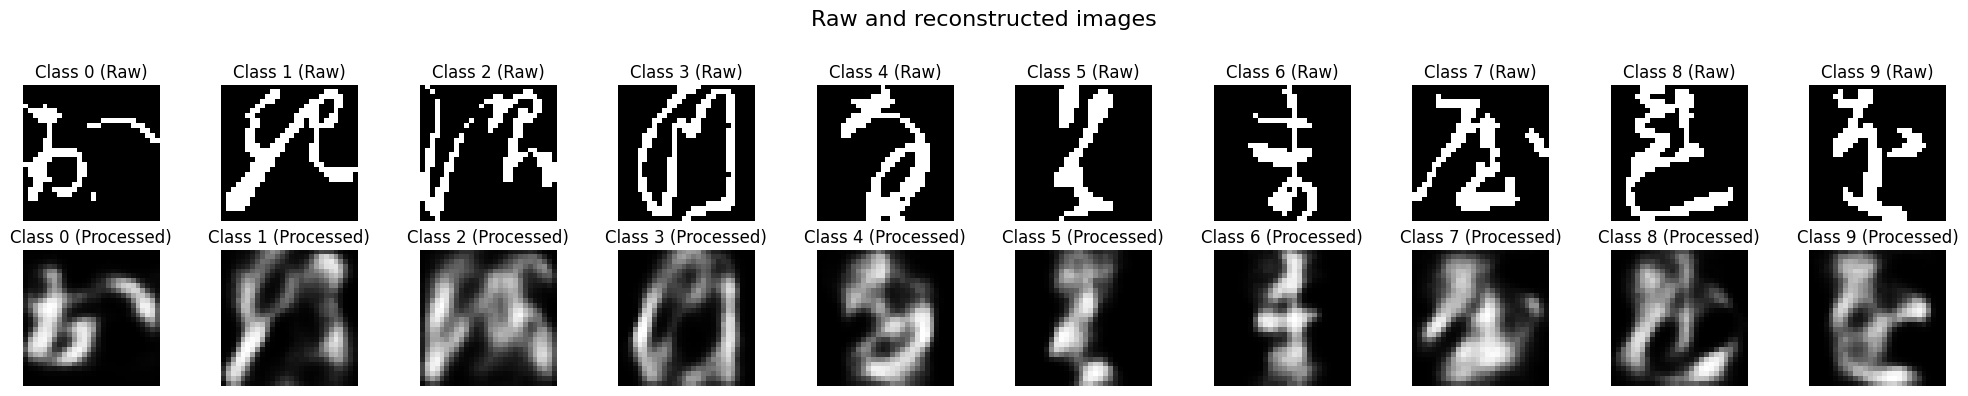

In [87]:
from skimage.metrics import structural_similarity as ssim

for data, name, rbm in zip(datasets, names, rbms):
    _, _, test_data, test_labels = data
    unique_classes = np.unique(test_labels)
    examples_idx = [np.where(test_labels == cls)[0][0] for cls in unique_classes]
    examples = test_data[examples_idx]
    reconstr = rbm.reconstruct(examples.reshape(examples.shape[0], -1))
    reconstr = reconstr.reshape(-1, 28, 28)

    n_clas = len(unique_classes)
    fig, axes = plt.subplots(2, 10, figsize=(2 * n_clas, 4))
    fig.suptitle("Raw and reconstructed images", fontsize=16)

    for i in range(n_clas):
        # Plot the raw image
        axes[0, i].imshow(examples[i], cmap="gray")
        axes[0, i].set_title(f"Class {unique_classes[i]} (Raw)")
        axes[0, i].axis("off")

        # Plot the processed image
        axes[1, i].imshow(reconstr[i], cmap="gray")
        axes[1, i].set_title(f"Class {unique_classes[i]} (Processed)")
        axes[1, i].axis("off")

    ssim_score = ssim(examples, reconstr, data_range=1.0)
    print(f"ssim score: {ssim_score}")

    # Adjust spacing
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
    plt.show()

Significant blur can be seen for kuzushiji dataset. Surprisingly great results can be seen for fashion mnist that also achieved the highest ssim score